# WAYRA-SAT

In [35]:
# Import libraries
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os
from collections import defaultdict
from causal_ccm import ccm
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_regression
from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle

## Data Preprocessing

### Shape File Provincias

In [2]:
# Shape file for provinces
gdf = gpd.read_file("./gadm41_ECU_shp/gadm41_ECU_1.shp").to_crs("EPSG:4326")
print(gdf["NAME_1"].unique())

# Excluir Galápagos y regiones insulares
gdf = gdf[~gdf["NAME_1"].str.contains("Galápagos|Insular", case=False)]

# Guardar versión limpia
gdf.to_file("./gadm41_ECU_shp/provincias_ecuador_continental.shp")

['Azuay' 'Bolivar' 'Cañar' 'Carchi' 'Chimborazo' 'Cotopaxi' 'El Oro'
 'Esmeraldas' 'Galápagos' 'Guayas' 'Imbabura' 'Loja' 'Los Rios' 'Manabi'
 'Morona Santiago' 'Napo' 'Orellana' 'Pastaza' 'Pichincha' 'Santa Elena'
 'Santo Domingo de los Tsachilas' 'Sucumbios' 'Tungurahua'
 'Zamora Chinchipe']


<Axes: >

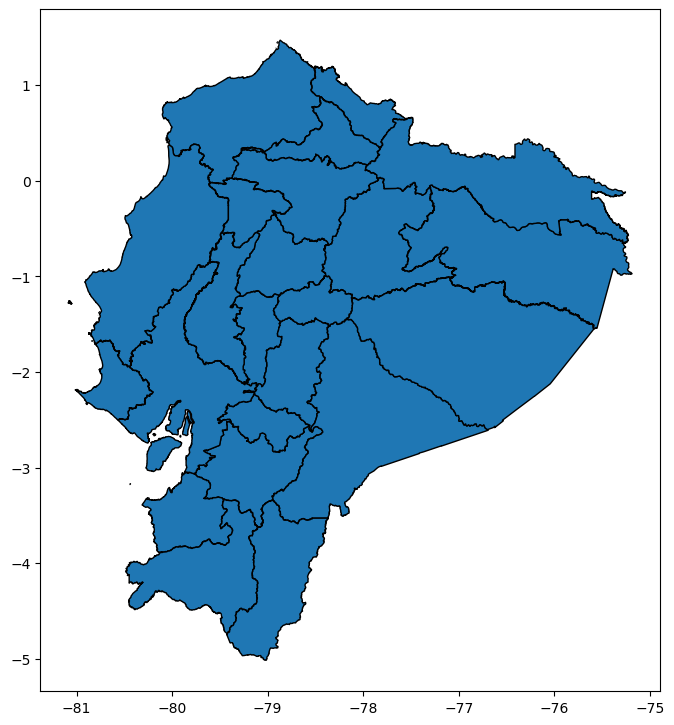

In [3]:
# Cargar shapefile limpio
gdf_prov = gpd.read_file("./gadm41_ECU_shp/provincias_ecuador_continental.shp").to_crs("EPSG:4326")
gdf_prov.plot(figsize=(8, 10), edgecolor='black')

### Test con un mes

In [4]:
# Test con un archivo
archivo_nc = "/home/arya/Projects/wayra_sat/era5/era5_land_1990_01.nc"
ds = xr.open_dataset(archivo_nc)

# Obtener coordenadas como pares
lats = ds.latitude.values
lons = ds.longitude.values
coords = [Point(lon, lat) for lat in lats for lon in lons]

# Crear dataframe auxiliar de puntos ERA5
df_points = pd.DataFrame({
    "geometry": coords,
    "lat": np.repeat(lats, len(lons)),
    "lon": np.tile(lons, len(lats))
})
gdf_points = gpd.GeoDataFrame(df_points, geometry="geometry", crs="EPSG:4326")

# Asociar cada punto a una provincia (una sola vez)
joined = gpd.sjoin(gdf_points, gdf_prov[["NAME_1", "geometry"]], how="inner", predicate="within")

# Resultado: lat/lon + provincia
asignaciones = joined[["lat", "lon", "NAME_1"]]

# Procesar fechas únicas
tiempos = pd.to_datetime(ds.valid_time.values)
fechas = np.unique(tiempos.date)

In [5]:
# Lista de resultados
resultados = []

for fecha in tqdm(fechas):
    mask_dia = tiempos.date == fecha
    ds_dia = ds.isel(valid_time=mask_dia)

    # Agregamos por día
    prcp_dia = ds_dia["tp"].sum(dim="valid_time") * 1000.0  # m → mm
    t2m_dia = ds_dia["t2m"].mean(dim="valid_time") - 273.15  # K → °C

    # Convertir a DataFrame plano
    df_valores = pd.DataFrame({
        "lat": np.repeat(lats, len(lons)),
        "lon": np.tile(lons, len(lats)),
        "precip_mm": prcp_dia.values.flatten(),
        "t2m_celsius": t2m_dia.values.flatten()
    })

    # Hacer merge con provincias
    df_merge = pd.merge(df_valores, asignaciones, on=["lat", "lon"])

    # Agregar por provincia
    df_agg = (
        df_merge
        .groupby("NAME_1")
        .agg(
            mean_precip = ("precip_mm",    "mean"),   # promedio espacial
            max_precip  = ("precip_mm",    "max"),    # pico extremo de lluvia
            mean_t2m    = ("t2m_celsius",  "mean"),   # promedio de temperatura
            max_t2m     = ("t2m_celsius",  "max"),    # pico extremo de temperatura
        )
        .reset_index()
    )
    df_agg["fecha"] = pd.to_datetime(fecha)
    resultados.append(df_agg)

# Unimos todos los días
df_final = pd.concat(resultados).reset_index(drop=True)
df_final = df_final[[
    "fecha",
    "NAME_1",
    "mean_precip", "max_precip",
    "mean_t2m",   "max_t2m"
]]
df_final

100%|█████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 27.45it/s]


,fecha,NAME_1,mean_precip,max_precip,mean_t2m,max_t2m
0,1990-01-01,Azuay,143.299637,338.607910,12.096319,20.602173
1,1990-01-01,Bolivar,65.364075,100.982819,14.626527,21.585876
2,1990-01-01,Carchi,131.828171,257.330048,13.684438,21.531433
3,1990-01-01,Cañar,61.751522,151.212311,12.248813,22.291290
4,1990-01-01,Chimborazo,104.756569,229.941116,9.523842,20.804626
...,...,...,...,...,...,...
708,1990-01-31,Santa Elena,7.136887,22.165718,26.246784,27.074829
709,1990-01-31,Santo Domingo de los Tsachilas,66.538025,212.575272,21.841347,24.327423
710,1990-01-31,Sucumbios,160.058762,346.227203,22.850437,25.032654
711,1990-01-31,Tungurahua,46.317600,68.360092,10.004049,16.735474


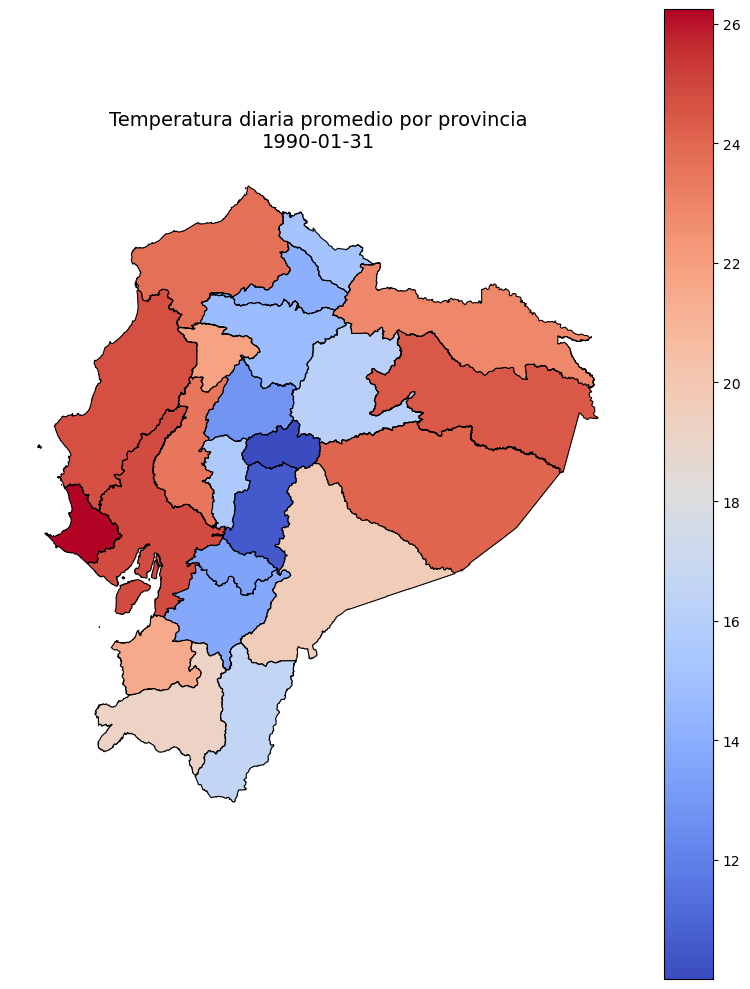

In [6]:
# Seleccionar fecha que quieres visualizar (ejemplo: primer día)
fecha_plot = df_final["fecha"].max()
df_dia = df_final[df_final["fecha"] == fecha_plot]

# Unir DataFrame con GeoDataFrame por nombre de provincia
gdf_mapa = gdf_prov.merge(df_dia, left_on="NAME_1", right_on="NAME_1")

# Graficar
fig, ax = plt.subplots(figsize=(8, 10))
gdf_mapa.plot(
    column="mean_t2m",
    cmap="coolwarm",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)
ax.set_title(f"Temperatura diaria promedio por provincia\n{fecha_plot.date()}", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

### Eventos Extremos por provincia

In [7]:
# Loop para todos los archivos
ruta_nc = "/home/arya/Projects/wayra_sat/era5/"
archivos_nc = sorted(glob.glob(os.path.join(ruta_nc, "era5_land_*.nc")))

df_por_mes = {}

# Asignaciones espaciales (solo se hace una vez)
ds_check = xr.open_dataset(archivos_nc[0])
lats = ds_check.latitude.values
lons = ds_check.longitude.values
coords = [Point(lon, lat) for lat in lats for lon in lons]

df_points = pd.DataFrame({
    "geometry": coords,
    "lat": np.repeat(lats, len(lons)),
    "lon": np.tile(lons, len(lats))
})
gdf_points = gpd.GeoDataFrame(df_points, geometry="geometry", crs="EPSG:4326")
joined = gpd.sjoin(gdf_points, gdf_prov[["NAME_1", "geometry"]], how="inner", predicate="within")
asignaciones = joined[["lat", "lon", "NAME_1"]]

# Acumular todos los días y celdas
cells_list = []
for archivo in archivos_nc:
    ds = xr.open_dataset(archivo)
    tiempos = pd.to_datetime(ds.valid_time.values)
    fechas = np.unique(tiempos.date)
    
    for fecha in fechas:
        mask = tiempos.date == fecha
        ds_d = ds.isel(valid_time=mask)
        
        prcp = (ds_d["tp"].sum(dim="valid_time") * 1000).values.flatten()
        t2m  = (ds_d["t2m"].mean(dim="valid_time") - 273.15).values.flatten()
        
        df_day = pd.DataFrame({
            "fecha": pd.to_datetime(fecha),
            "lat": np.repeat(lats, len(lons)),
            "lon": np.tile(lons, len(lats)),
            "prcp_mm": prcp,
            "t2m_c":   t2m
        })
        
        # Merge con asignaciones para obtener NAME_1
        df_day = df_day.merge(asignaciones, on=["lat","lon"], how="inner")
        cells_list.append(df_day)

In [8]:
# Concatenar todo
df_cells = pd.concat(cells_list, ignore_index=True)

# Añadir día del año (doy)
df_cells['doy'] = df_cells['fecha'].dt.dayofyear

# Mostrar las primeras filas para verificar
df_cells.head()

,fecha,lat,lon,prcp_mm,t2m_c,NAME_1,doy
0,1990-01-01,1.4,-78.8,52.802849,23.783234,Esmeraldas,1
1,1990-01-01,1.3,-78.9,67.978775,23.872589,Esmeraldas,1
2,1990-01-01,1.3,-78.8,67.176140,23.810974,Esmeraldas,1
3,1990-01-01,1.3,-78.7,68.294540,23.464722,Esmeraldas,1
4,1990-01-01,1.2,-79.0,59.412689,24.156769,Esmeraldas,1


In [9]:
# Calculando climatología (media histórica) para cada celda y doy
df_cells['clim_prcp'] = (
    df_cells
    .groupby(['lat','lon','doy'])['prcp_mm']
    .transform('mean')
)
df_cells['clim_t2m'] = (
    df_cells
    .groupby(['lat','lon','doy'])['t2m_c']
    .transform('mean')
)

# Desviación estándar histórica por celda y doy
df_cells['std_prcp'] = (
    df_cells
    .groupby(['lat','lon','doy'])['prcp_mm']
    .transform('std')
)
df_cells['std_t2m'] = (
    df_cells
    .groupby(['lat','lon','doy'])['t2m_c']
    .transform('std')
)

# Cálculo de anomalías absolutas
df_cells['anom_prcp'] = df_cells['prcp_mm'] - df_cells['clim_prcp']
df_cells['anom_t2m']  = df_cells['t2m_c']  - df_cells['clim_t2m']

# Mostrar un vistazo al resultado
df_cells[['fecha','lat','lon','NAME_1','doy','prcp_mm','clim_prcp','anom_prcp',
          't2m_c','clim_t2m','anom_t2m']].head()

,fecha,lat,lon,NAME_1,doy,prcp_mm,clim_prcp,anom_prcp,t2m_c,clim_t2m,anom_t2m
0,1990-01-01,1.4,-78.8,Esmeraldas,1,52.802849,171.043182,-118.240334,23.783234,24.433104,-0.649870
1,1990-01-01,1.3,-78.9,Esmeraldas,1,67.978775,175.573090,-107.594315,23.872589,24.628473,-0.755884
2,1990-01-01,1.3,-78.8,Esmeraldas,1,67.176140,176.312607,-109.136467,23.810974,24.481087,-0.670113
3,1990-01-01,1.3,-78.7,Esmeraldas,1,68.294540,196.311020,-128.016479,23.464722,24.152086,-0.687365
4,1990-01-01,1.2,-79.0,Esmeraldas,1,59.412689,157.884109,-98.471420,24.156769,24.975048,-0.818279


In [10]:
# Definir función para la media de las celdas top X%
def mean_top_frac(x, frac=0.10):
    n = max(1, int(len(x) * frac))
    return x.nlargest(n).mean()

# Calcular media de top 10% de anomalías de precipitación por provincia y día
df_prov_top10_prcp = (
    df_cells
    .groupby(['fecha', 'NAME_1'])['anom_prcp']
    .apply(lambda x: mean_top_frac(x, frac=0.10))
    .reset_index(name='prov_top10_mean_anom_prcp')
)

# Calcular media de top 10% de anomalías de temperatura por provincia y día
df_prov_top10_t2m = (
    df_cells
    .groupby(['fecha', 'NAME_1'])['anom_t2m']
    .apply(lambda x: mean_top_frac(x, frac=0.10))
    .reset_index(name='prov_top10_mean_anom_t2m')
)

# Unir ambas métricas
df_prov_top10 = pd.merge(
    df_prov_top10_prcp,
    df_prov_top10_t2m,
    on=['fecha', 'NAME_1']
)

# Mostrar resultado
df_prov_top10.head()

,fecha,NAME_1,prov_top10_mean_anom_prcp,prov_top10_mean_anom_t2m
0,1990-01-01,Azuay,204.511841,-0.269778
1,1990-01-01,Bolivar,-1.108388,-0.243314
2,1990-01-01,Carchi,93.387146,-0.280296
3,1990-01-01,Cañar,60.209023,-0.347873
4,1990-01-01,Chimborazo,146.285172,0.023700


In [11]:
# Calcular umbrales percentiles (p95 por defecto) sobre la media top10 de anomalías
th_prcp = (
    df_prov_top10
    .groupby('NAME_1')['prov_top10_mean_anom_prcp']
    .quantile(0.95)
    .reset_index(name='threshold_prcp_top10')
)
th_t2m = (
    df_prov_top10
    .groupby('NAME_1')['prov_top10_mean_anom_t2m']
    .quantile(0.95)
    .reset_index(name='threshold_t2m_top10')
)

# Unir umbrales con la serie diaria top10
df_events_top10 = (
    df_prov_top10
    .merge(th_prcp, on='NAME_1', how='left')
    .merge(th_t2m,  on='NAME_1', how='left')
)

# Marcar eventos extremos basados en percentiles
df_events_top10['extreme_prcp_top10'] = (
    df_events_top10['prov_top10_mean_anom_prcp'] >
    df_events_top10['threshold_prcp_top10']
).astype(int)

df_events_top10['extreme_t2m_top10'] = (
    df_events_top10['prov_top10_mean_anom_t2m'] >
    df_events_top10['threshold_t2m_top10']
).astype(int)

# Vista previa
df_events_top10.head()

,fecha,NAME_1,prov_top10_mean_anom_prcp,prov_top10_mean_anom_t2m,threshold_prcp_top10,threshold_t2m_top10,extreme_prcp_top10,extreme_t2m_top10
0,1990-01-01,Azuay,204.511841,-0.269778,676.649878,1.931913,0,0
1,1990-01-01,Bolivar,-1.108388,-0.243314,1570.247290,1.488232,0,0
2,1990-01-01,Carchi,93.387146,-0.280296,1242.299335,1.553484,0,0
3,1990-01-01,Cañar,60.209023,-0.347873,491.286028,1.861539,0,0
4,1990-01-01,Chimborazo,146.285172,0.023700,949.786569,1.593450,0,0


In [12]:
df_events_top10_pr = df_events_top10[df_events_top10['extreme_prcp_top10']==1]
df_events_top10_pr

,fecha,NAME_1,prov_top10_mean_anom_prcp,prov_top10_mean_anom_t2m,threshold_prcp_top10,threshold_t2m_top10,extreme_prcp_top10,extreme_t2m_top10
9,1990-01-01,Imbabura,574.710754,-0.238365,545.736215,1.545428,1,0
152,1990-01-07,Napo,778.641785,0.005687,503.957715,1.540852,1,0
160,1990-01-07,Zamora Chinchipe,695.709839,0.034970,272.666939,1.718189,1,0
183,1990-01-08,Zamora Chinchipe,284.519165,-0.513748,272.666939,1.718189,1,0
247,1990-01-11,Pichincha,478.468811,0.363477,393.984959,1.675784,1,0
...,...,...,...,...,...,...,...,...
92392,2000-12-31,Bolivar,1621.391235,0.223310,1570.247290,1.488232,1,0
92393,2000-12-31,Carchi,1848.338379,0.208069,1242.299335,1.553484,1,0
92396,2000-12-31,Cotopaxi,875.562622,0.163366,847.316486,1.609159,1,0
92398,2000-12-31,Esmeraldas,1345.241821,0.101234,758.878915,1.553407,1,0


In [13]:
df_events_top10_tm = df_events_top10[df_events_top10['extreme_t2m_top10']==1]
df_events_top10_tm

,fecha,NAME_1,prov_top10_mean_anom_prcp,prov_top10_mean_anom_t2m,threshold_prcp_top10,threshold_t2m_top10,extreme_prcp_top10,extreme_t2m_top10
13,1990-01-01,Morona Santiago,110.482307,2.031223,381.970784,1.703613,0,1
15,1990-01-01,Orellana,-11.416453,4.008300,350.593587,1.874448,0,1
16,1990-01-01,Pastaza,6.330732,3.816095,323.401257,1.763817,0,1
20,1990-01-01,Sucumbios,73.330315,3.833392,425.523108,1.896457,0,1
38,1990-01-02,Orellana,-23.257088,3.408467,350.593587,1.874448,0,1
...,...,...,...,...,...,...,...,...
91308,2000-11-13,Tungurahua,-35.184639,1.870848,256.199899,1.521045,0,1
91331,2000-11-14,Tungurahua,22.679382,1.654774,256.199899,1.521045,0,1
91701,2000-12-01,Azuay,-24.635809,1.947248,676.649878,1.931913,0,1
91724,2000-12-02,Azuay,63.090618,2.544467,676.649878,1.931913,0,1


### Sea Surface Temperature

In [14]:
# Ruta a tus archivos sst
archivos_nc = sorted(glob.glob("./ostia/sst_*.nc"))

# Lista donde guardar los resultados diarios
resultados = []

for archivo in archivos_nc:
    ds = xr.open_dataset(archivo)

    # Extraer SST con escala y offset
    sst_raw = ds['analysed_sst'].astype('float32')
    sst = sst_raw * 0.01 

    # Calcular promedio espacial para cada día del mes
    for i in range(sst.sizes['time']):
        fecha = np.datetime64(ds.time[i].values, 'D')
        media = float(sst.isel(time=i).mean().values)
        resultados.append((fecha, media))

# Crear DataFrame
df_sst = pd.DataFrame(resultados, columns=["fecha", "sst_nino3.4_C"])
df_sst.to_csv("serie_diaria_sst_nino3.4.csv", index=False)

In [15]:
df_sst

,fecha,sst_nino3.4_C
0,1990-01-01,2.993487
1,1990-01-02,2.993935
2,1990-01-03,2.994116
3,1990-01-04,2.994423
4,1990-01-05,2.994122
...,...,...
4013,2000-12-27,2.988679
4014,2000-12-28,2.987978
4015,2000-12-29,2.987256
4016,2000-12-30,2.987312


In [16]:
# Definir manualmente la tabla de anomalías ONI (1990-2000, temporadas solapadas)
oni_data = [
    [1990,  0.1,  0.2,  0.3,  0.3,  0.3,  0.3,  0.3,  0.4,  0.4,  0.3,  0.4,  0.4],
    [1991,  0.4,  0.3,  0.2,  0.3,  0.5,  0.6,  0.7,  0.6,  0.6,  0.8,  1.2,  1.5],
    [1992,  1.7,  1.6,  1.5,  1.3,  1.1,  0.7,  0.4,  0.1, -0.1, -0.2, -0.3, -0.1],
    [1993,  0.1,  0.3,  0.5,  0.7,  0.7,  0.6,  0.3,  0.3,  0.2,  0.1,  0.0,  0.1],
    [1994,  0.1,  0.1,  0.2,  0.3,  0.4,  0.4,  0.4,  0.4,  0.6,  0.7,  1.0,  1.1],
    [1995,  1.0,  0.7,  0.5,  0.3,  0.1,  0.0, -0.2, -0.5, -0.8, -1.0, -1.0, -1.0],
    [1996, -0.9, -0.8, -0.6, -0.4, -0.3, -0.3, -0.3, -0.3, -0.4, -0.4, -0.4, -0.5],
    [1997, -0.5, -0.4, -0.1,  0.3,  0.8,  1.2,  1.6,  1.9,  2.1,  2.3,  2.4,  2.4],
    [1998,  2.2,  1.9,  1.4,  1.0,  0.5, -0.1, -0.8, -1.1, -1.3, -1.4, -1.5, -1.6],
    [1999, -1.5, -1.3, -1.1, -1.0, -1.0, -1.0, -1.1, -1.1, -1.2, -1.3, -1.5, -1.7],
    [2000, -1.7, -1.4, -1.1, -0.8, -0.7, -0.6, -0.6, -0.5, -0.5, -0.6, -0.7, -0.7],
]
oni_cols = ['Year','DJF','JFM','FMA','MAM','AMJ','MJJ','JJA','JAS','ASO','SON','OND','NDJ']
oni_anom_df = pd.DataFrame(oni_data, columns=oni_cols)

In [17]:
oni_anom_df

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
0,1990,0.1,0.2,0.3,0.3,0.3,0.3,0.3,0.4,0.4,0.3,0.4,0.4
1,1991,0.4,0.3,0.2,0.3,0.5,0.6,0.7,0.6,0.6,0.8,1.2,1.5
2,1992,1.7,1.6,1.5,1.3,1.1,0.7,0.4,0.1,-0.1,-0.2,-0.3,-0.1
3,1993,0.1,0.3,0.5,0.7,0.7,0.6,0.3,0.3,0.2,0.1,0.0,0.1
4,1994,0.1,0.1,0.2,0.3,0.4,0.4,0.4,0.4,0.6,0.7,1.0,1.1
5,1995,1.0,0.7,0.5,0.3,0.1,0.0,-0.2,-0.5,-0.8,-1.0,-1.0,-1.0
6,1996,-0.9,-0.8,-0.6,-0.4,-0.3,-0.3,-0.3,-0.3,-0.4,-0.4,-0.4,-0.5
7,1997,-0.5,-0.4,-0.1,0.3,0.8,1.2,1.6,1.9,2.1,2.3,2.4,2.4
8,1998,2.2,1.9,1.4,1.0,0.5,-0.1,-0.8,-1.1,-1.3,-1.4,-1.5,-1.6
9,1999,-1.5,-1.3,-1.1,-1.0,-1.0,-1.0,-1.1,-1.1,-1.2,-1.3,-1.5,-1.7


In [18]:
# Convertir a formato largo (una fila por Year-temporada)
oni_long = oni_anom_df.melt(id_vars='Year', var_name='season', value_name='oni_anomaly')

# Mapear temporada → mes central
season_to_month = {
    'DJF':1, 'JFM':2, 'FMA':3, 'MAM':4,
    'AMJ':5, 'MJJ':6, 'JJA':7, 'JAS':8,
    'ASO':9, 'SON':10,'OND':11,'NDJ':12
}
oni_long['month'] = oni_long['season'].map(season_to_month)

# Construir year_month como Period y mantener un valor por mes
oni_long['year_month'] = pd.to_datetime(
    dict(year=oni_long.Year, month=oni_long.month, day=1)
).dt.to_period('M')
monthly_oni = oni_long.drop_duplicates('year_month')[['year_month','oni_anomaly']].set_index('year_month')

# Etiquetar EN/LN/N usando umbrales ±0.5 °C
monthly_oni['oni_event'] = monthly_oni['oni_anomaly'].apply(
    lambda x: 'EN' if x >=  0.5 else ('LN' if x <= -0.5 else 'N')
)

# Unir la etiqueta al DataFrame diario df_sst
df_sst['year_month'] = df_sst['fecha'].dt.to_period('M')
df_sst = (
    df_sst
    .merge(monthly_oni['oni_event'], left_on='year_month', right_index=True, how='left')
    .drop(columns='year_month')
)

# Resultado final
df_sst

,fecha,sst_nino3.4_C,oni_event
0,1990-01-01,2.993487,N
1,1990-01-02,2.993935,N
2,1990-01-03,2.994116,N
3,1990-01-04,2.994423,N
4,1990-01-05,2.994122,N
...,...,...,...
4013,2000-12-27,2.988679,LN
4014,2000-12-28,2.987978,LN
4015,2000-12-29,2.987256,LN
4016,2000-12-30,2.987312,LN


## Covergent Cross Mapping

In [19]:
# Crear Dataframes por provincia

# Merge de anomalías provinciales con SST
df_merged = pd.merge(
    df_events_top10,
    df_sst[['fecha', 'sst_nino3.4_C', 'oni_event']],
    on='fecha',
    how='inner'
)

# Opcional: quedarte solo con lo esencial
cols = [
    'fecha', 'NAME_1',
    'prov_top10_mean_anom_prcp', 'prov_top10_mean_anom_t2m',
    'sst_nino3.4_C'
]
df_merged = df_merged[cols]

# 3A. Opción: diccionario de DataFrames por provincia
df_por_prov = {
    prov: df_merged[df_merged['NAME_1'] == prov].reset_index(drop=True)
    for prov in df_merged['NAME_1'].unique()
}


In [20]:
df_por_prov['Pichincha']

,fecha,NAME_1,prov_top10_mean_anom_prcp,prov_top10_mean_anom_t2m,sst_nino3.4_C
0,1990-01-01,Pichincha,283.744629,-0.323384,2.993487
1,1990-01-02,Pichincha,33.437195,-0.205823,2.993935
2,1990-01-03,Pichincha,7.796841,0.215898,2.994116
3,1990-01-04,Pichincha,7.937710,0.654860,2.994423
4,1990-01-05,Pichincha,146.937622,0.820174,2.994122
...,...,...,...,...,...
4013,2000-12-27,Pichincha,135.250824,0.363906,2.988679
4014,2000-12-28,Pichincha,211.470520,0.024099,2.987978
4015,2000-12-29,Pichincha,88.444710,-0.132398,2.987256
4016,2000-12-30,Pichincha,40.273460,0.262817,2.987312


In [21]:
# Calcula estadísticas globales de SST (ONI)
mu_sst    = df_sst['sst_nino3.4_C'].mean()
sigma_sst = df_sst['sst_nino3.4_C'].std(ddof=0)

# Recorre cada DataFrame provincial y estandariza
df_ccm_por_prov = {}

for prov, df_p in df_por_prov.items():
    # Prcp z-score (media y sigma de la provincia)
    mu_prcp   = df_p['prov_top10_mean_anom_prcp'].mean()
    sigma_prcp= df_p['prov_top10_mean_anom_prcp'].std(ddof=0)
    df_p['prcp_z'] = (df_p['prov_top10_mean_anom_prcp'] - mu_prcp) / sigma_prcp

    # T2m z-score (media y sigma de la provincia)
    mu_t2m    = df_p['prov_top10_mean_anom_t2m'].mean()
    sigma_t2m = df_p['prov_top10_mean_anom_t2m'].std(ddof=0)
    df_p['t2m_z']  = (df_p['prov_top10_mean_anom_t2m'] - mu_t2m) / sigma_t2m

    # SST z-score (misma escala para todas las provincias)
    df_p['sst_z']  = (df_p['sst_nino3.4_C'] - mu_sst) / sigma_sst

    # Guarda el DataFrame estandarizado
    df_ccm_por_prov[prov] = df_p[['fecha','NAME_1','prcp_z','t2m_z','sst_z']].copy()


In [22]:
df_ccm_por_prov['Pichincha']

,fecha,NAME_1,prcp_z,t2m_z,sst_z
0,1990-01-01,Pichincha,1.052178,-1.451569,-0.755683
1,1990-01-02,Pichincha,-0.355834,-1.260038,-0.715265
2,1990-01-03,Pichincha,-0.500064,-0.572969,-0.699029
3,1990-01-04,Pichincha,-0.499272,0.142188,-0.671346
4,1990-01-05,Pichincha,0.282621,0.411518,-0.698470
...,...,...,...,...,...
4013,2000-12-27,Pichincha,0.216881,-0.331833,-1.188707
4014,2000-12-28,Pichincha,0.645627,-0.885448,-1.251868
4015,2000-12-29,Pichincha,-0.046409,-1.140413,-1.316898
4016,2000-12-30,Pichincha,-0.317379,-0.496529,-1.311916


In [36]:
with open('df_ccm_por_prov.pkl', 'wb') as f:
    pickle.dump(df_ccm_por_prov, f)

#### Temperatura

In [23]:
# Encontrar la E correcta por provincia
df_pichincha = df_por_prov['Pichincha'].copy()

# Extraemos la serie normalizada de temperatura
y = df_pichincha['t2m_z'].values

def simplex_skill(y, E, tau=1):
    """
    Calcula la skill (ρ) de Simplex Projection para embedding dimension E,
    usando delay tau y k = E+1 vecinos. Predicción de un paso ahead.
    """
    N = len(y)
    M = N - (E - 1) * tau - 1
    embed = np.column_stack([y[i * tau : i * tau + M] for i in range(E)])
    targets = y[(E - 1) * tau + 1 : (E - 1) * tau + 1 + M]
    
    k = E + 1
    nbrs = NearestNeighbors(n_neighbors=k).fit(embed)
    _, indices = nbrs.kneighbors(embed)
    
    preds = [targets[inds[1:]].mean() for inds in indices]
    rho = np.corrcoef(preds, targets)[0,1]
    return rho

# Calcular ρ para E desde 1 hasta 8
results = []
for E in range(1, 9):
    rho = simplex_skill(y, E)
    results.append({'E': E, 'rho': rho})

df_results = pd.DataFrame(results)

# Mostrar la tabla de resultados al usuario
df_results


,E,rho
0,1,0.671746
1,2,0.730903
2,3,0.760291
3,4,0.769866
4,5,0.781058
5,6,0.784627
6,7,0.789882
7,8,0.790182


In [24]:
# Define tu función de skill (misma que antes)
def simplex_skill(y, E, tau=1):
    N = len(y)
    M = N - (E - 1)*tau - 1
    embed = np.column_stack([y[i*tau : i*tau + M] for i in range(E)])
    targets = y[(E-1)*tau + 1 : (E-1)*tau + 1 + M]
    k = E + 1
    nbrs = NearestNeighbors(n_neighbors=k).fit(embed)
    _, idx = nbrs.kneighbors(embed)
    preds = [targets[inds[1:]].mean() for inds in idx]
    return np.corrcoef(preds, targets)[0,1]

In [25]:
# Parámetros
Es = list(range(1,9))
epsilon = 0.01 

# Loop sobre provincias
results = []
for prov, df_p in df_ccm_por_prov.items():
    y = df_p['t2m_z'].values    
    rhos = [simplex_skill(y, E) for E in Es]
    
    # Incrementos relativos entre E y E+1
    rel_inc = [(rhos[i+1] - rhos[i]) / rhos[i] for i in range(len(Es)-1)]
    
    # Encuentra el primer E+1 donde mejora < epsilon
    E_star = next((Es[i+1] for i, d in enumerate(rel_inc) if d < epsilon), Es[-1])
    rho_star = rhos[Es.index(E_star)]
    
    results.append({
        'NAME_1': prov,
        'E_star': E_star,
        'rho_at_E_star': rho_star
    })

In [26]:
df_E_temp = pd.DataFrame(results)
print(df_E_temp)

                            NAME_1  E_star  rho_at_E_star
0                            Azuay       5       0.798060
1                          Bolivar       5       0.741944
2                           Carchi       6       0.799989
3                            Cañar       5       0.792925
4                       Chimborazo       7       0.738950
5                         Cotopaxi       7       0.800925
6                           El Oro       5       0.866587
7                       Esmeraldas       5       0.825330
8                           Guayas       5       0.882790
9                         Imbabura       5       0.808089
10                            Loja       5       0.806972
11                        Los Rios       6       0.770027
12                          Manabi       6       0.854267
13                 Morona Santiago       5       0.696767
14                            Napo       6       0.671783
15                        Orellana       4       0.668285
16            

In [27]:
def compute_mutual_info(series, max_lag=30, n_neighbors=3):
    mis = []
    y = series.values
    for lag in range(1, max_lag+1):
        X = y[:-lag].reshape(-1,1)
        Y = y[lag:]
        mi = mutual_info_regression(X, Y, n_neighbors=n_neighbors, random_state=0)
        mis.append(mi[0])
    return np.array(mis)

def false_nearest_neighbors(series, E, tau):
    y = series.values
    N = len(y)
    M = N - (E * tau)
    # Construir embedding para E y E+1
    def embed_dim(d):
        return np.column_stack([y[i * tau : i * tau + M] for i in range(d)])
    emb_E = embed_dim(E)
    emb_E1 = embed_dim(E+1)
    nbrs = NearestNeighbors(n_neighbors=2).fit(emb_E)
    distances, indices = nbrs.kneighbors(emb_E)
    R = np.std(y)
    fnn_count = 0
    for i, inds in enumerate(indices):
        j = inds[1]
        dist_E = distances[i,1]
        dist_E1 = np.linalg.norm(emb_E1[i] - emb_E1[j])
        # criterio Kennel: (dist_E1 - dist_E)/dist_E > R
        if (dist_E1 - dist_E) / dist_E > 10:  # umbral típico 10
            fnn_count += 1
    return fnn_count / M

# Parámetros
max_lag = 30
results = []

for prov, df_p in df_ccm_por_prov.items():
    # Mutual Information
    mis = compute_mutual_info(df_p['t2m_z'], max_lag=max_lag)
    tau_mi = np.argmin(mis) + 1
    
    # Validate with FNN at embedding dimension E_star (as obtenido antes)
    E_star = df_E_temp.loc[df_E_temp['NAME_1']==prov, 'E_star'].values[0]
    fnn_ratio = false_nearest_neighbors(df_p['t2m_z'], E_star, tau_mi)
    
    results.append({
        'NAME_1': prov,
        'tau_mi': tau_mi,
        'fnn_ratio': fnn_ratio
    })

df_tau_mi = pd.DataFrame(results)
df_tau_mi

,NAME_1,tau_mi,fnn_ratio
0,Azuay,28,0.007994
1,Bolivar,28,0.004899
2,Carchi,23,0.000000
3,Cañar,23,0.007943
4,Chimborazo,26,0.000000
5,Cotopaxi,30,0.000000
6,El Oro,22,0.007165
7,Esmeraldas,26,0.006173
8,Guayas,27,0.006438
9,Imbabura,28,0.006962


### Precipitación

In [28]:
# Re-definimos simplex_skill para la variable efecto
def simplex_skill_pr(y, E, tau=1):
    N = len(y)
    M = N - (E - 1)*tau - 1
    embed = np.column_stack([y[i*tau : i*tau + M] for i in range(E)])
    targets = y[(E-1)*tau + 1 : (E-1)*tau + 1 + M]
    nbrs = NearestNeighbors(n_neighbors=E+1).fit(embed)
    _, idx = nbrs.kneighbors(embed)
    preds = [targets[inds[1:]].mean() for inds in idx]
    return np.corrcoef(preds, targets)[0,1]

# Version mejorada con suavizado de lluvia de 7 dias
df_ccm_por_prov_sm = {}
for prov, df_p in df_ccm_por_prov.items():
    df = df_p.copy()
    # centered rolling mean de ventana 3
    df['prcp_smooth'] = df['prcp_z'].rolling(window=3, center=True, min_periods=1).mean()
    df_ccm_por_prov_sm[prov] = df

# Parámetros
Es = list(range(1,9))
epsilon = 0.01 

# Loop sobre provincias
results = []
for prov, df_p in df_ccm_por_prov_sm.items():
    y = df_p['prcp_smooth'].values    
    rhos = [simplex_skill_pr(y, E) for E in Es]
    
    # Incrementos relativos entre E y E+1
    rel_inc = [(rhos[i+1] - rhos[i]) / rhos[i] for i in range(len(Es)-1)]
    
    # Encuentra el primer E+1 donde mejora < epsilon
    E_star = next((Es[i+1] for i, d in enumerate(rel_inc) if d < epsilon), Es[-1])
    rho_star = rhos[Es.index(E_star)]
    
    results.append({
        'NAME_1': prov,
        'E_star': E_star,
        'rho_at_E_star': rho_star
    })

In [29]:
df_E_pr = pd.DataFrame(results)
print(df_E_pr)

                            NAME_1  E_star  rho_at_E_star
0                            Azuay       4       0.890573
1                          Bolivar       5       0.892491
2                           Carchi       5       0.780876
3                            Cañar       5       0.874656
4                       Chimborazo       5       0.898843
5                         Cotopaxi       5       0.845710
6                           El Oro       5       0.860979
7                       Esmeraldas       5       0.791408
8                           Guayas       5       0.892283
9                         Imbabura       5       0.770685
10                            Loja       5       0.847795
11                        Los Rios       5       0.876009
12                          Manabi       5       0.833260
13                 Morona Santiago       5       0.817477
14                            Napo       5       0.845026
15                        Orellana       6       0.784604
16            

In [30]:
# Loop para precipitación
results_prcp = []
max_lag = 15
for prov, df_p in df_ccm_por_prov_sm.items():
    y = df_p['prcp_smooth']
    mis = compute_mutual_info(y, max_lag=max_lag)
    # opcional: graficar mis para un par de provincias
    tau_mi = np.argmin(mis) + 1
    E_star = int(df_E_pr.loc[df_E_pr['NAME_1']==prov, 'E_star'].values[0])
    fnn = false_nearest_neighbors(y, E_star, tau_mi)
    results_prcp.append({'NAME_1': prov, 'tau_mi_prcp': tau_mi, 'fnn_ratio_prcp': fnn})

df_tau_prcp = pd.DataFrame(results_prcp)
print(df_tau_prcp)

                            NAME_1  tau_mi_prcp  fnn_ratio_prcp
0                            Azuay            9        0.097187
1                          Bolivar           14        0.036981
2                           Carchi            7        0.022596
3                            Cañar           12        0.022233
4                       Chimborazo           14        0.045593
5                         Cotopaxi           15        0.036013
6                           El Oro           10        0.038306
7                       Esmeraldas           13        0.037946
8                           Guayas           15        0.066954
9                         Imbabura            7        0.037158
10                            Loja            8        0.029663
11                        Los Rios           14        0.029889
12                          Manabi           14        0.054205
13                 Morona Santiago            8        0.040724
14                            Napo      

### Matriz de Causalidad

### Temperatura

In [50]:
# Parameters for Pichincha embedding (as example)
prov = 'Pichincha'
E_t   = int(df_E_pr.loc[df_E_pr.NAME_1 == prov, 'E_star'].iloc[0])
tau_t = int(df_tau_prcp.loc[df_tau_prcp.NAME_1 == prov, 'tau_mi_prcp'].iloc[0])

# Data for Pichincha
df_p = df_ccm_por_prov[prov].reset_index(drop=True)
dates = pd.to_datetime(df_p['fecha'])

# Sliding window size:
window_size = 180

# Containers for results
sliding_results = []

# Range of lead times to test
lead_range = range(0, 61) 

# Loop over days allowing a full window
for idx in tqdm(range(window_size - 1, len(df_p)), desc="Sliding CCM 180d"):
    sub = df_p.iloc[idx - window_size + 1 : idx + 1]
    Y = sub['prcp_z'].values
    X = sub['sst_z'].values

    best_rho = -np.inf
    best_lead = None
    best_pval = None

    # Test each lead time within the window
    for lt in lead_range:
        X_shift = np.roll(X, lt)
        c = ccm(X_shift, Y, tau_t, E_t, len(Y))
        rho, _ = c.causality()
        if rho > best_rho:
            best_rho = rho
            best_lead = lt

    sliding_results.append({
        'fecha':    dates.iloc[idx],
        'tau_lead': best_lead,
        'rho':      best_rho,
        'pval':      best_pval
    })

Sliding CCM 180d: 100%|███████████████████████████████████| 3839/3839 [20:08<00:00,  3.18it/s]


In [51]:
df_pichincha = pd.DataFrame(sliding_results)
df_pichincha

,fecha,tau_lead,rho,pval
0,1990-06-29,35,0.095407,None
1,1990-06-30,35,0.141442,None
2,1990-07-01,35,0.178508,None
3,1990-07-02,35,0.200035,None
4,1990-07-03,35,0.192998,None
...,...,...,...,...
3834,2000-12-27,23,0.319773,None
3835,2000-12-28,23,0.318863,None
3836,2000-12-29,23,0.350730,None
3837,2000-12-30,24,0.305605,None


In [52]:
# 1. Selecciona y renombra las columnas de anomalías del primer DataFrame
df1 = (
    df_ccm_por_prov['Pichincha']
    [['fecha', 'sst_z', 'prcp_z']]
    .rename(columns={
        'sst_z': 'sst_anomaly',
        'prcp_z': 'pr_anomaly'
    })
)

# 2. Selecciona y renombra las columnas relevantes del segundo DataFrame
df2 = (
    df_pichincha
    [['fecha', 'tau_lead', 'rho']]
    .rename(columns={
        'tau_lead': 'time_lead'
    })
)

# 3. Haz el merge por fecha
df_final = pd.merge(df1, df2, on='fecha')

# 4. Guarda el resultado en un archivo pickle
df_final.to_pickle('ccm_pichincha_pr.pkl')

# (Opcional) Ver un vistazo de las primeras filas
print(df_final.head())

       fecha  sst_anomaly  pr_anomaly  time_lead       rho
0 1990-06-29     0.245944    0.112227         35  0.095407
1 1990-06-30     0.234067   -0.536589         35  0.141442
2 1990-07-01     0.255393   -0.674040         35  0.178508
3 1990-07-02     0.264070   -0.533112         35  0.200035
4 1990-07-03     0.213622   -0.476720         35  0.192998


In [53]:
# Parameters for Pichincha embedding (as example)
prov = 'Carchi'
E_t   = int(df_E_pr.loc[df_E_pr.NAME_1 == prov, 'E_star'].iloc[0])
tau_t = int(df_tau_prcp.loc[df_tau_prcp.NAME_1 == prov, 'tau_mi_prcp'].iloc[0])

# Data for Pichincha
df_p = df_ccm_por_prov[prov].reset_index(drop=True)
dates = pd.to_datetime(df_p['fecha'])

# Sliding window size:
window_size = 180

# Containers for results
sliding_results = []

# Range of lead times to test
lead_range = range(0, 61) 

# Loop over days allowing a full window
for idx in tqdm(range(window_size - 1, len(df_p)), desc="Sliding CCM 180d"):
    sub = df_p.iloc[idx - window_size + 1 : idx + 1]
    Y = sub['prcp_z'].values
    X = sub['sst_z'].values

    best_rho = -np.inf
    best_lead = None
    best_pval = None

    # Test each lead time within the window
    for lt in lead_range:
        X_shift = np.roll(X, lt)
        c = ccm(X_shift, Y, tau_t, E_t, len(Y))
        rho, _ = c.causality()
        if rho > best_rho:
            best_rho = rho
            best_lead = lt

    sliding_results.append({
        'fecha':    dates.iloc[idx],
        'tau_lead': best_lead,
        'rho':      best_rho,
        'pval':      best_pval
    })

Sliding CCM 180d: 100%|███████████████████████████████████| 3839/3839 [24:28<00:00,  2.62it/s]


In [54]:
df_carchi = pd.DataFrame(sliding_results)
df_carchi

,fecha,tau_lead,rho,pval
0,1990-06-29,26,0.191551,None
1,1990-06-30,30,0.201194,None
2,1990-07-01,30,0.200419,None
3,1990-07-02,28,0.206373,None
4,1990-07-03,35,0.214040,None
...,...,...,...,...
3834,2000-12-27,15,0.203698,None
3835,2000-12-28,15,0.168689,None
3836,2000-12-29,15,0.127733,None
3837,2000-12-30,15,0.130585,None


In [55]:
# 1. Selecciona y renombra las columnas de anomalías del primer DataFrame
df1 = (
    df_ccm_por_prov['Carchi']
    [['fecha', 'sst_z', 'prcp_z']]
    .rename(columns={
        'prcp_z': 'sst_anomaly',
        't2m_z': 'pr_anomaly'
    })
)

# 2. Selecciona y renombra las columnas relevantes del segundo DataFrame
df2 = (
    df_carchi
    [['fecha', 'tau_lead', 'rho']]
    .rename(columns={
        'tau_lead': 'time_lead'
    })
)

# 3. Haz el merge por fecha
df_final = pd.merge(df1, df2, on='fecha')

# 4. Guarda el resultado en un archivo pickle
df_final.to_pickle('ccm_carchi_pr.pkl')

# (Opcional) Ver un vistazo de las primeras filas
print(df_final.head())

       fecha     sst_z  sst_anomaly  time_lead       rho
0 1990-06-29  0.245944    -0.495059         26  0.191551
1 1990-06-30  0.234067    -0.488626         30  0.201194
2 1990-07-01  0.255393    -0.664902         30  0.200419
3 1990-07-02  0.264070    -0.614388         28  0.206373
4 1990-07-03  0.213622     0.601810         35  0.214040


In [56]:
# Parameters for Pichincha embedding (as example)
prov = 'Los Rios'
E_t   = int(df_E_pr.loc[df_E_pr.NAME_1 == prov, 'E_star'].iloc[0])
tau_t = int(df_tau_prcp.loc[df_tau_prcp.NAME_1 == prov, 'tau_mi_prcp'].iloc[0])

# Data for Pichincha
df_p = df_ccm_por_prov[prov].reset_index(drop=True)
dates = pd.to_datetime(df_p['fecha'])

# Sliding window size:
window_size = 180

# Containers for results
sliding_results = []

# Range of lead times to test
lead_range = range(0, 61) 

# Loop over days allowing a full window
for idx in tqdm(range(window_size - 1, len(df_p)), desc="Sliding CCM 180d"):
    sub = df_p.iloc[idx - window_size + 1 : idx + 1]
    Y = sub['prcp_z'].values
    X = sub['sst_z'].values

    best_rho = -np.inf
    best_lead = None
    best_pval = None

    # Test each lead time within the window
    for lt in lead_range:
        X_shift = np.roll(X, lt)
        c = ccm(X_shift, Y, tau_t, E_t, len(Y))
        rho, _ = c.causality()
        if rho > best_rho:
            best_rho = rho
            best_lead = lt

    sliding_results.append({
        'fecha':    dates.iloc[idx],
        'tau_lead': best_lead,
        'rho':      best_rho,
        'pval':      best_pval
    })

Sliding CCM 180d: 100%|███████████████████████████████████| 3839/3839 [20:44<00:00,  3.08it/s]


In [57]:
df_losrios = pd.DataFrame(sliding_results)
df_losrios

,fecha,tau_lead,rho,pval
0,1990-06-29,49,0.211740,None
1,1990-06-30,48,0.176622,None
2,1990-07-01,60,0.224605,None
3,1990-07-02,59,0.195833,None
4,1990-07-03,58,0.195052,None
...,...,...,...,...
3834,2000-12-27,0,0.460565,None
3835,2000-12-28,0,0.448824,None
3836,2000-12-29,0,0.450350,None
3837,2000-12-30,0,0.436943,None


In [58]:
# 1. Selecciona y renombra las columnas de anomalías del primer DataFrame
df1 = (
    df_ccm_por_prov['Los Rios']
    [['fecha', 'sst_z', 'prcp_z']]
    .rename(columns={
        'prcp_z': 'sst_anomaly',
        't2m_z': 'pr_anomaly'
    })
)

# 2. Selecciona y renombra las columnas relevantes del segundo DataFrame
df2 = (
    df_losrios
    [['fecha', 'tau_lead', 'rho']]
    .rename(columns={
        'tau_lead': 'time_lead'
    })
)

# 3. Haz el merge por fecha
df_final = pd.merge(df1, df2, on='fecha')

# 4. Guarda el resultado en un archivo pickle
df_final.to_pickle('ccm_losrios_pr.pkl')

# (Opcional) Ver un vistazo de las primeras filas
print(df_final.head())

       fecha     sst_z  sst_anomaly  time_lead       rho
0 1990-06-29  0.245944    -0.581147         49  0.211740
1 1990-06-30  0.234067    -0.602685         48  0.176622
2 1990-07-01  0.255393    -0.714904         60  0.224605
3 1990-07-02  0.264070    -0.508859         59  0.195833
4 1990-07-03  0.213622     0.627276         58  0.195052
